# Digit Recognition
Learn computer vision fundamentals with the famous MNIST data

Link to the contest: https://www.kaggle.com/competitions/digit-recognizer/

Rank - 292

Score - 0.99275


## Downloading the dataset

In [1]:
# Using collab and pasted the kaggle.json in the content file

import os

# Create the directory
os.makedirs('/root/.config/kaggle/', exist_ok=True)

# Copy the kaggle.json file to the directory (updated path)
!cp /content/kaggle.json /root/.config/kaggle/


!chmod 600 /root/.config/kaggle/kaggle.json


In [2]:
!kaggle competitions download -c digit-recognizer

 72% 11.0M/15.3M [00:00<00:00, 114MB/s]
100% 15.3M/15.3M [00:00<00:00, 82.1MB/s]


In [3]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Loading the data

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

In [92]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [93]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From data, we have a 28*28 pixel value for the images.
In the training dataset, we also have the label of the images as "label" column.

Let's visualise some random data points and verify their labels.

## EDA and Data Preprocessing


The data is all numerical.

Since we are working with image data, other analysis also might be different to conventional machine learning techniques.

1. Check for missing values.
2. Add maybe more images using data augmentation techniques.

In [95]:
train_size = train.shape
test_size = test.shape
print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  (42000, 785)
Test size:  (28000, 784)


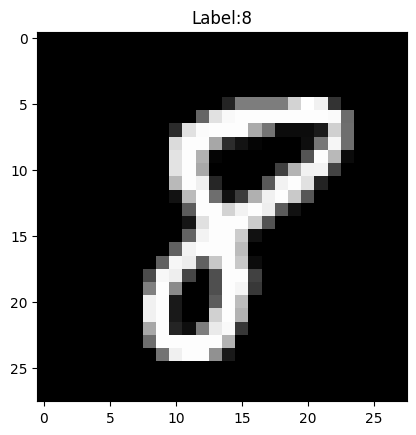

In [96]:
# Try running the below code multiple times to visualize the images and corresponding labels

datapoint = train.iloc[random.randint(0,train_size[0])]
label = datapoint['label']
image = datapoint.drop('label').values.reshape(28,28)
plt.imshow(image,cmap ='gray')
plt.title(f'Label:{label}')
plt.show()

In [97]:
train_ds = train.copy()
test_ds = test.copy()

In [98]:
train_ds.isna().sum().sum() #No missing values

0

Using ImageDataGenerator to augment training images.

In [141]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X = train_ds.drop('label',axis = 1).values.reshape(-1,28,28,1)
y = train_ds['label'].values

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)

datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8,1.2],
    shear_range = 0.1
)

datagen.fit(X_train)

## Model Training



Starting with a simple dense layers deep learning model.


In [100]:
from tensorflow.keras.callbacks import EarlyStopping

model_simple = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(32,activation = 'relu'),
        tf.keras.layers.Dense(10)
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
model_simple.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor
    patience=3,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights
    verbose=1                     # Print a message when early stopping is triggered
)

batch_size = 32
epochs = 25

history = model_simple.fit(
    datagen.flow(X_train,y_train,batch_size = batch_size),
    validation_data = (X_val,y_val),
    epochs = epochs,
    callbacks = [early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.2039 - loss: 5.7986 - val_accuracy: 0.4338 - val_loss: 1.6356
Epoch 2/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.3847 - loss: 1.7441 - val_accuracy: 0.6195 - val_loss: 1.1415
Epoch 3/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5384 - loss: 1.3507 - val_accuracy: 0.7043 - val_loss: 0.8935
Epoch 4/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6481 - loss: 1.0682 - val_accuracy: 0.7805 - val_loss: 0.6334
Epoch 5/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7161 - loss: 0.8752 - val_accuracy: 0.8345 - val_loss: 0.5030
Epoch 6/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7728 - loss: 0.7040 - val_accuracy: 0.8779 - val_loss: 0.3994
Epoch 7/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8283 - loss: 0.5605 - val_accuracy: 0.9202 - val_loss: 0.2699
Epoch 8/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8593 - loss: 0.47

We got a validation accuracy of 0.9470 with out simple deep learning model.

In [103]:
def plot_loss(history):
  # Plot training vs validation loss
  plt.figure(figsize=(10, 6))

  # Training and validation loss
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')

  # Add labels and title
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Show the plot
  plt.show()


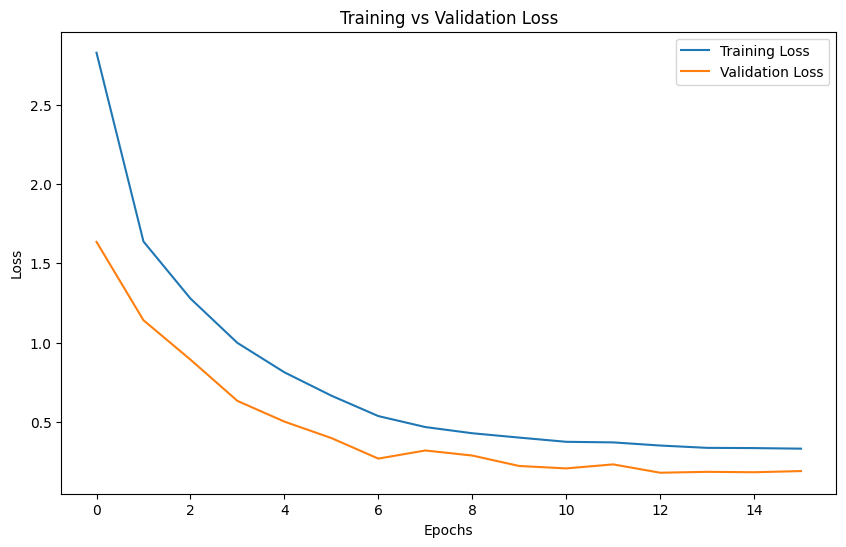

In [104]:
plot_loss(history)

Trying deep learning network with convolution layer as CNNs are good in capturing spatial information and provide better results in general than

In [72]:
model_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
model_CNN.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor
    patience=5,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights
    verbose=1                     # Print a message when early stopping is triggered
)

batch_size = 32
epochs = 25

history_CNN = model_CNN.fit(
    datagen.flow(X_train,y_train,batch_size = batch_size),
    validation_data = (X_val,y_val),
    epochs = epochs,
    callbacks = [early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.1865 - loss: 4.1525 - val_accuracy: 0.8275 - val_loss: 0.6287
Epoch 2/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5926 - loss: 1.1669 - val_accuracy: 0.9555 - val_loss: 0.1544
Epoch 3/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8075 - loss: 0.6118 - val_accuracy: 0.9762 - val_loss: 0.0813
Epoch 4/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8651 - loss: 0.4490 - val_accuracy: 0.9798 - val_loss: 0.0707
Epoch 5/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.8945 - loss: 0.3535 - val_accuracy: 0.9814 - val_loss: 0.0666
Epoch 6/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9091 - loss: 0.3079 - val_accuracy: 0.9760 - val_loss: 0.0866
Epoch 7/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9162 - loss: 0.2856 - val_accuracy: 0.9852 - val_loss: 0.0548
Epoch 8/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9191 - loss: 0.27

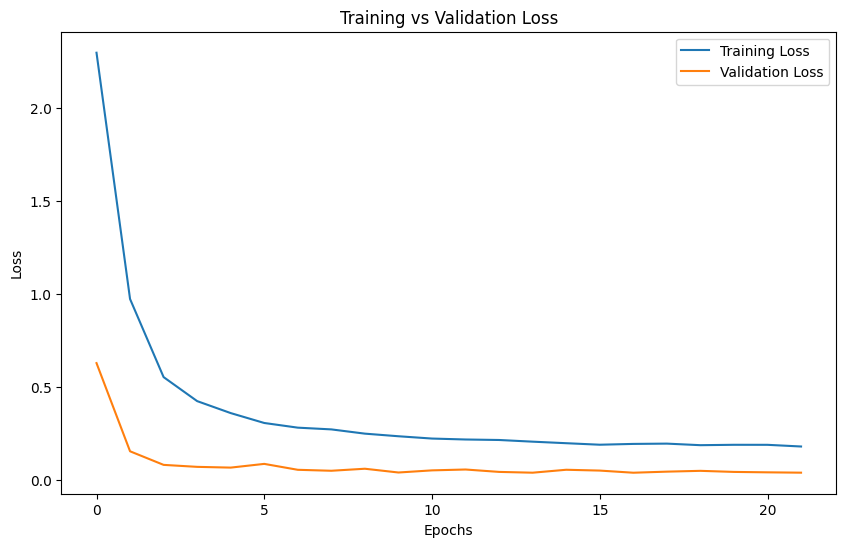

In [106]:
plot_loss(history_CNN)

In [132]:
model_CNN_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
model_CNN_2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor
    patience=5,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights
    verbose=1                     # Print a message when early stopping is triggered
)

batch_size = 32
epochs = 25

history_CNN2 = model_CNN_2.fit(
    datagen.flow(X_train,y_train,batch_size = batch_size),
    validation_data = (X_val,y_val),
    epochs = epochs,
    callbacks = [early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.8715 - loss: 0.4055 - val_accuracy: 0.9686 - val_loss: 0.0963
Epoch 2/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9730 - loss: 0.0884 - val_accuracy: 0.9836 - val_loss: 0.0546
Epoch 3/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9782 - loss: 0.0677 - val_accuracy: 0.9873 - val_loss: 0.0419
Epoch 4/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9820 - loss: 0.0595 - val_accuracy: 0.9860 - val_loss: 0.0444
Epoch 5/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9851 - loss: 0.0484 - val_accuracy: 0.9894 - val_loss: 0.0305
Epoch 6/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9855 - loss: 0.0458 - val_accuracy: 0.9907 - val_loss: 0.0295
Epoch 7/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9871 - loss: 0.0391 - val_accuracy: 0.9917 - val_loss: 0.0261
Epoch 8/25
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9882 - loss: 0.03

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


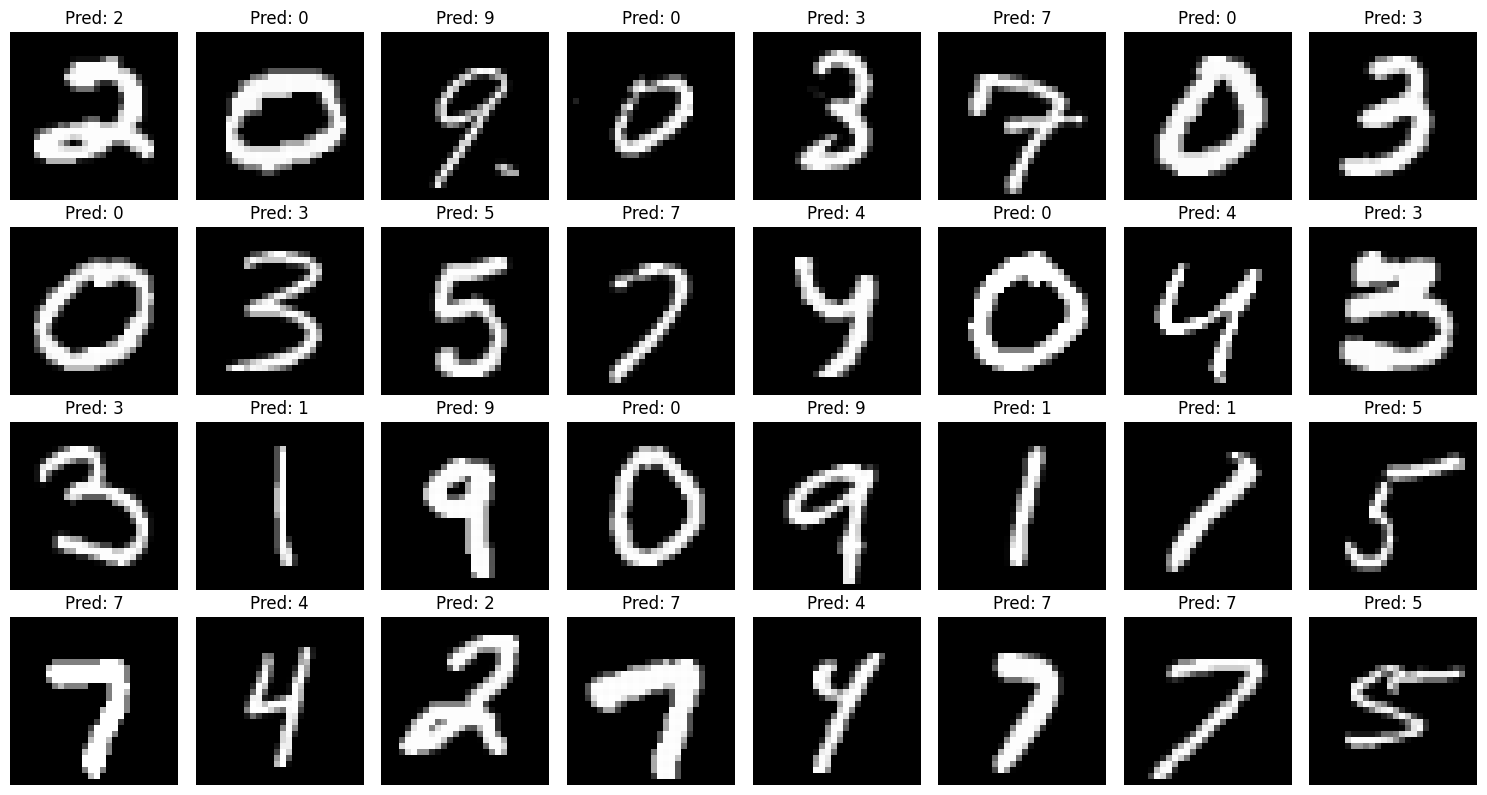

In [134]:
# Prepare the test images
test_ds = test.copy()
test_np = test_ds.values.reshape(-1, 28, 28, 1)

# Prepare the list of images
temp = []
for i in range(32):  # We want to plot the first 32 images
    temp.append(test_np[i])

# Convert to numpy array and reshape
temp = np.array(temp).reshape(-1, 28, 28, 1)

# Get predictions for all 32 images
predictions = model_CNN_2.predict(temp)

# Create a figure to plot the images
fig, axes = plt.subplots(4, 8, figsize=(15, 8))  # 4 rows and 8 columns
axes = axes.ravel()

# Loop through each image and plot
for i in range(32):
    image = test_ds.iloc[i].values.reshape(28, 28)
    label = np.argmax(predictions[i])  # Get the predicted label

    # Plot each image with the predicted label as the title
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Pred: {label}")
    axes[i].axis('off')  # Hide the axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Submission

In [135]:
predictions = model_CNN_2.predict(test_np)


875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [136]:
predictions.shape

(28000, 10)

In [137]:
pred = []
for i in predictions:
  pred.append(np.argmax(i))

In [138]:
submission = pd.DataFrame({
    'ImageId': [i for i in range(1,28001)],  # Replace with appropriate identifier
    'Label': pred # Replace with the predictions from the best model
})

In [139]:
submission.to_csv('submission.csv', index=False)

In [140]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"

100% 208k/208k [00:00<00:00, 1.23MB/s]
Successfully submitted to Digit Recognizer